# DPX Temperature Analysis

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import hickle, cPickle
import scipy.stats
%matplotlib inline

import plotTemperatureToT as pttt
import ToTtoEnergy as tte
reload(tte)

sys.path.insert(0, '../../../energy_calibration/rebin/')
import rebin as rb

## Input Files

In [2]:
infile = '../../dpx_data/temperatureToT_5.hck'

## Combine files

In [3]:
# energyList = [30, 40, 50, 75, 100, 125, 148]
# infileList = ['temperatureToT_wSensor/temperatureToT_%d.p' % energy for energy in energyList]
energyList = [25, 75, 125]
infileList = ['../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_%dkeV.hck' % energy for energy in energyList]

def combineFiles(infileList, energyList):
    # Get first file
    if infileList[0].endswith('.p'):
        d = cPickle.load(open(infileList[0], 'rb'))
    else:
        d = hickle.load(infileList[0])

    # Add energy column if needed
    if not 'energy' in d.keys():
        energy = energyList[0] * 1000
        d['energy'] = [energy]*len(d['time'])

    dim = min(len(d['energy']), len(d['ToT']), len(d['time']))
    for key in d.keys():
        d[key] = d[key][:dim]
        
    for idx, infile in enumerate(infileList[1:]):
        print infile
        if infileList[idx].endswith('.p'):
            d_ = cPickle.load(open(infile, 'rb'))
        else:
            d_ = hickle.load(infile)
                        
        if not 'energy' in d_.keys():
            energy = energyList[idx+1] * 1000
            d_['energy'] = [energy]*len(d_['time'])
            
        dim = min(len(d_['energy']), len(d_['ToT']), len(d_['time']))
        for key in d_.keys():
            d_[key] = d_[key][:dim]
            
        for key in d.keys():
            d[key] += list(d_[key])
            
    return d

tempDict = combineFiles(infileList, energyList)

../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_75keV.hck
../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_125keV.hck


In [4]:
print set(tempDict['energy'])
len(tempDict['energy']), len(tempDict['time']), len(tempDict['ToT'])

set([25000.0, 75000.0, 125000.0])


(695, 695, 695)

## Perform calibration and return parameters for each pixel

plotTemperatureToT.py:272: RuntimeWarning: overflow encountered in exp
  return np.where(x <= toff, offset1, np.where(x <= tmax, (Tmax - offset1)*(1 - np.exp(-tau1*(x - toff))) + offset1, (Tmax - offset2)*np.exp(-tau2*(x - tmax)) + offset2))
plotTemperatureToT.py:272: RuntimeWarning: overflow encountered in multiply
  return np.where(x <= toff, offset1, np.where(x <= tmax, (Tmax - offset1)*(1 - np.exp(-tau1*(x - toff))) + offset1, (Tmax - offset2)*np.exp(-tau2*(x - tmax)) + offset2))
/usr/lib/python2.7/dist-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


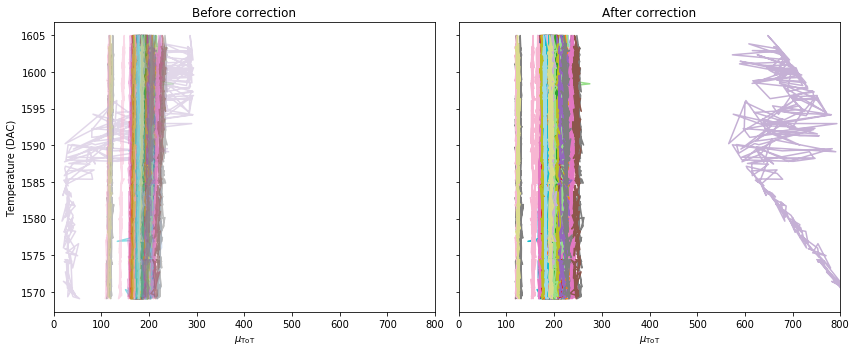

<Figure size 432x288 with 0 Axes>

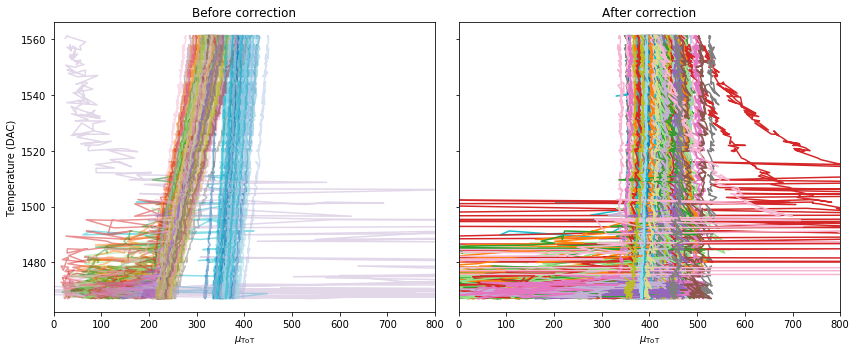

<Figure size 432x288 with 0 Axes>

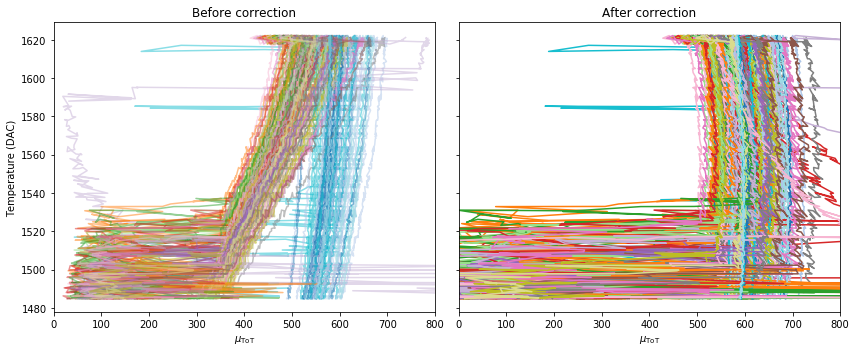

<Figure size 432x288 with 0 Axes>

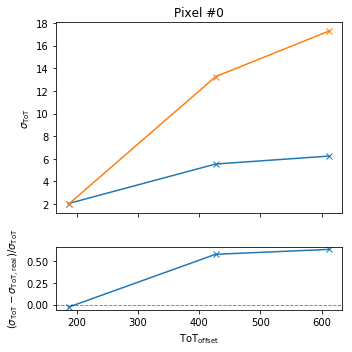

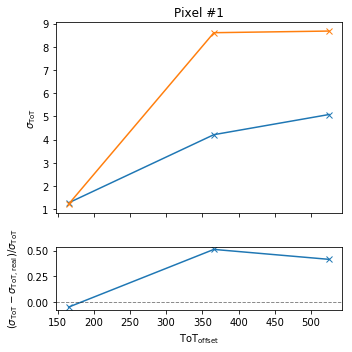

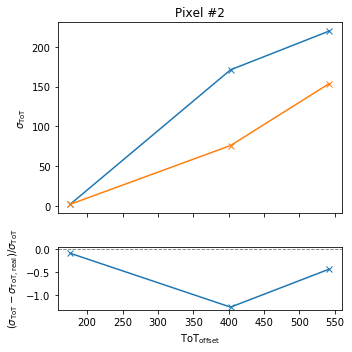

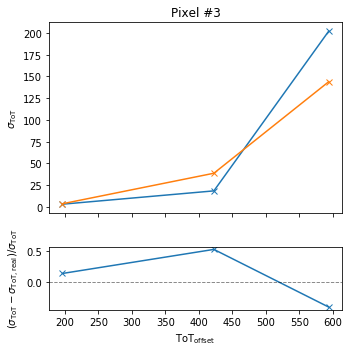

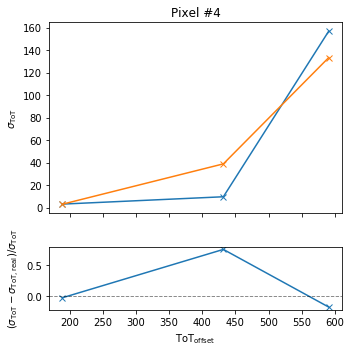

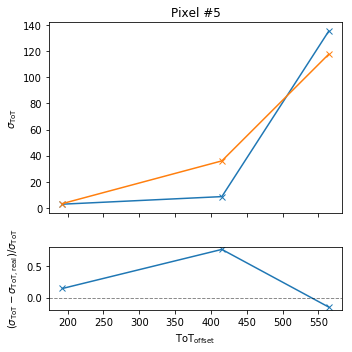

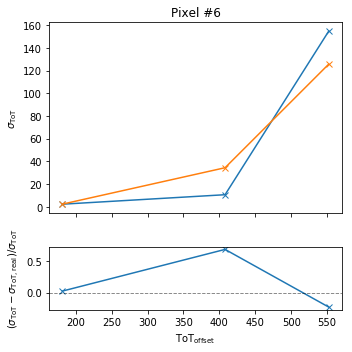

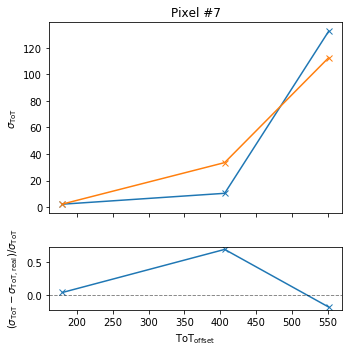

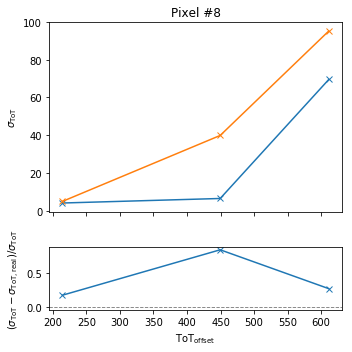

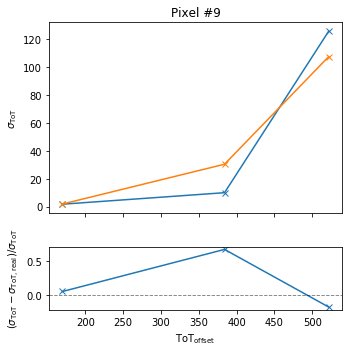

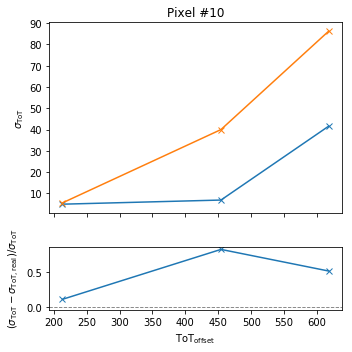

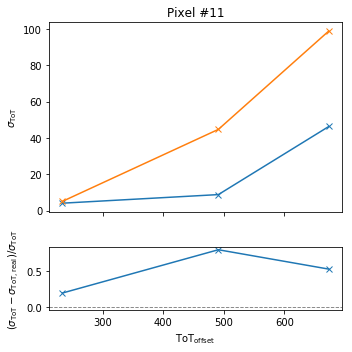

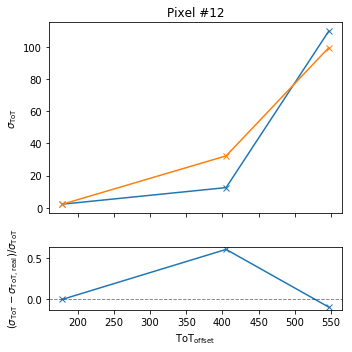

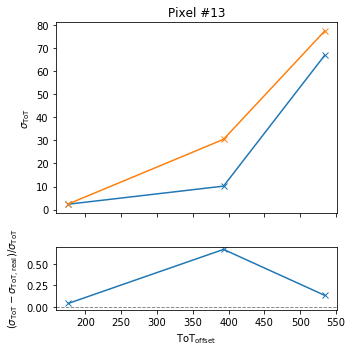

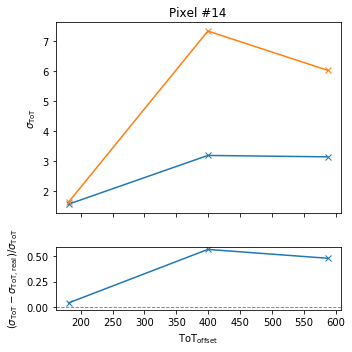

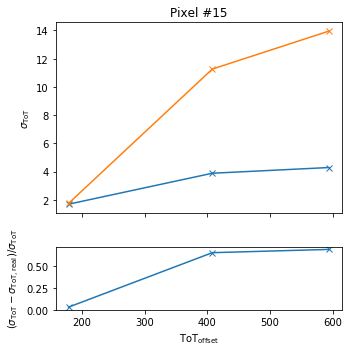

In [5]:
reload(pttt)
# Load dict from file
if infile.endswith('.p'):
    d = cPickle.load( open(infile, 'rb') )
else:
    d = hickle.load(infile)

outDict = pttt.plotTemperature(tempDict, offsettemp=1635, plot=False, outdir=None)

## Simulate temperature effects on measured data

In [6]:
# Get energy calibration coefficients
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')

# Load spectrum from file
ToTfnList = ['../../dpx_data/Measurements/DPX22/AmMo_raw/ToTMeasurement_%d.hck' % num for num in range(5, 11)]
dataList = [np.asarray( hickle.load(open(ToTfn, 'r'))['Slot1'] ).T for ToTfn in ToTfnList]
# Combine the data
data = np.hstack(dataList)

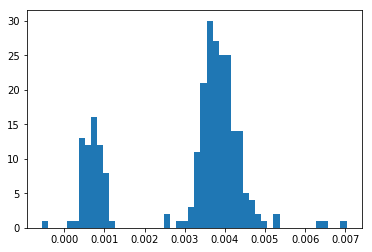

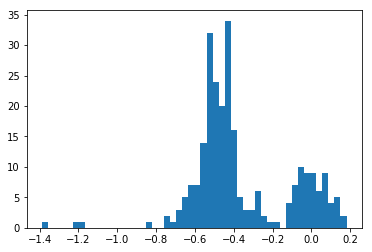

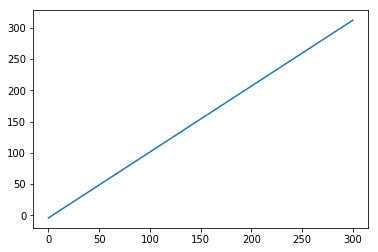

In [7]:
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']
_ = plt.hist(slope, bins=50)
plt.show()
_ = plt.hist(offset[abs(offset - np.mean(offset)) < 3*np.std(offset)], bins=50)
plt.show()

plt.plot(np.linspace(0, 300, 10), pttt.getRealToT(np.linspace(0, 300, 10), Toffset, 1650, slope[8], offset[8]))

In [23]:
def ToTtoEnergy(data, params):
    pixelData = data
    # pixelData = pixelData[pixelData > 0]
    p = params
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']

    pixelDataEnergy = tte.ToTtoEnergy(pixelData, a, b, c, t, h, k)
    # pixelDataEnergy = pixelDataEnergy[np.logical_and(pixelDataEnergy > 10, pixelDataEnergy <= 100)]

    return pixelDataEnergy

def ToTatT(data, T, slope, offset, Toffset):
    data = np.asarray( data )
    # data = data[data > 0]
    dataAtT = pttt.getRealToT(data, T, Toffset, slope, offset)
    return dataAtT
    
def getDataAtT(data, T, slope, offset, Toffset, energy=True):
    dataEnergyList = []
    for idx in range(256):
        try:
            dataEnergy = getDataAtTSingle(data[idx], T, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=energy)
            dataEnergyList.append( dataEnergy )
        except:
            continue
    
    return dataEnergyList
    
def getDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True, rmZero=False):
    dataAtT = np.asarray( ToTatT(data, T, slope, offset, Toffset) )
    if rmZero:
        dataAtT = dataAtT[dataAtT > 0]
    # try:
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    # except:
    #     return None
    
    return dataEnergy
    
Toffset = 1635
TList= np.linspace(Toffset - 100, Toffset + 100, 100)
xMin, xMax = 10, 400
saveFig = False

if saveFig:
    binsList, histList = [], []
    for T in TList:
        dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=True)
        dataTemp = np.asarray( dataTemp ).flatten()
        hist, bins = np.histogram(dataTemp, bins=np.arange(xMin, xMax))
        binsList.append(bins), histList.append(hist)

    for idx in range(len(TList)):
        plt.step(binsList[idx][:-1], histList[idx], where='post', alpha=.7)
        plt.title('Temperature: %d DAC' % TList[idx])
        plt.ylim(0, 1.05*np.max(histList))
        plt.savefig('images/temperature_%d.jpg' % idx)
        plt.show()
        plt.clf()

## Bin energy data

In [9]:
def normal(x, mu, sigma):
    return 1./np.sqrt(2*sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def KDE(bins, hist):
    bins, hist = np.asarray(bins), np.asarray(hist)
    
    # Get bin widths
    binWidths = np.diff(bins)
    
    # Get bin centers
    binCenters = bins[:-1] # + 0.5 * binWidths
    
    f = lambda x: sum([hist[idx] * normal(x, binCenters[idx], .5 * binWidths[idx]) for idx in range(len(hist))])
    return f

def getCorrectedBins(bins, hist):
    # Get gradient
    grad = np.diff(np.insert(hist, 0, 0)) # / np.diff(bins)
    print grad

    binEdges = []
    binWidths = np.diff(bins[:-1])
    for i in range(len(grad) - 1):
        g1, g2 = grad[i], grad[i+1]
        b = bins[i] # + 0.5 * binWidths[i]
        bw = binWidths[i]

        if g1 == 0 and g2 == 0:
            binEdges.append(b + 0.5*bw)
            continue

        gFrac = abs(g1 / g2)
        if np.isinf(gFrac):
            gFrac = 0

        if gFrac > 1:
            gFrac = 1. / gFrac

        if i == 0:
            if gFrac < 0.5:
                gFrac = 1 - gFrac
            
        elif g1 >= 0 and g2 >= 0:
            if gFrac < 0.5:
                gFrac = 1 - gFrac

        elif g1 < 0 and g2 < 0:
            if gFrac >= 0.5:
                gFrac = 1 - gFrac

        elif g1 >= 0 and g2 < 0:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac
            gFrac /= 2

        else:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac

        binEdges.append(b + bw * gFrac)
        print grad[i], grad[i+1], gFrac, b

    return binEdges

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.01010101e-05
  9.27698033e-04  4.82843472e-03 -4.12287712e-03 -1.64335664e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.22621564e-04  1.68591966e-02 -4.60793854e-03 -1.23729424e-02]
0.0 1.01010101010101e-05 1.0 21.0
1.01010101010101e-05 0.0009276980329611909 0.9891117478510029 24.5
0.0009276980329611909 0.0048284347231715655 0.8078677488360387 33.5
0.0048284347231715655 -0.004122877122877123 0.42693723320846766 43.0
-0.004122877122877123 -0.0016433566433566432 0.39859462078992 53.5
-0.0016433566433566432 0.0 0 66.5
0.0 0.0001226215644820296 1.0 131.5
0.0001226215644820296 0.01685919661733615 0.9927267255216693 151.5
0.01685919661733615 -0.0046079385403329075 0.1366594934777203 173.0
-0.0046079385403329075 -0.012372942434362499 0.372420591526847 200.5
[ 15.    19.5   22.75  29.    38.25  48.25  60.    74.    89.25 105.
 122.25 141.5  162.25 186.75 218.25 333.  ]
[15.0, 19.5, 24.5, 33.40200573065903, 41.174743

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


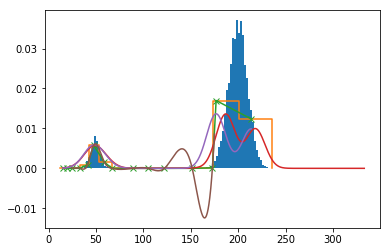

In [10]:
def smearSpectrumKDE(data, amplitude, sigma, bins):
    x = np.linspace(min(data), max(data), bins)
    print data
    y = np.sum(np.asarray([amplitude[i] * scipy.stats.norm.pdf(x - mu, scale=sigma) for i, mu in enumerate(data)]), axis=0)

    return x, y

binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
rand_data = list(np.random.normal(200, 10, 10000)) + list(np.random.normal(50, 5, 1000))
hist, bins = np.histogram(rand_data, bins=binEdges, density=True)

bins_corr = getCorrectedBins(bins, hist)

plt.hist(rand_data, bins=100, density=True)
plt.step(bins[:-1], hist, where='post')
plt.plot(bins_corr, hist[:-1], marker='x')
plt.plot(*smearSpectrumKDE(bins[:-1] + 0.5 * np.diff(bins), 20*hist, 10, 1000))
plt.plot(*smearSpectrumKDE(bins_corr, 20*hist[:-1], 10, 1000))

f = scipy.interpolate.interp1d(bins_corr, hist[:-1], kind='cubic')
x = np.linspace(25, 175, 1000)
plt.plot(x, f(x))

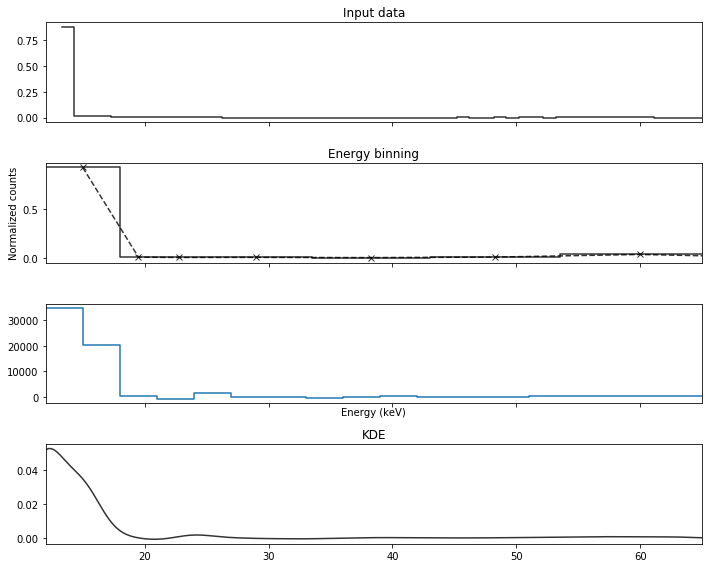

In [11]:
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
# binEdges = [12, 40, 42, 44, 50, 55, 56, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
idx = 8

# Input data
pixelData = ToTtoEnergy(data[idx], paramsDict[idx])
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 100)]
histIn, binsIn = np.histogram(pixelData, bins=75)
ax[0].step(binsIn[:-1], histIn / float(np.sum(histIn)), where='post', color='k', alpha=.8)
ax[0].set_xlim(binEdges[0], 65)
ax[0].set_title('Input data')

# Apply energy bins
hist, bins = np.histogram(pixelData, bins=binEdges)
ax[1].step(bins[:-1], hist / float(np.sum(hist)), where='post', color='k', alpha=.8)
ax[1].plot(bins[:-1] + 0.5 * np.diff(bins), hist / float(np.sum(hist)), marker='x', ls='--', color='k', alpha=.8)
ax[1].set_title('Energy binning')

# Rebin energy
x = np.arange(binEdges[0], binEdges[-2], min(np.diff(binEdges))) # np.linspace(binEdges[0], binEdges[-2], 16)
x = np.append(x, binEdges[-1])
y = rb.rebin(bins, hist, x) # , interp_kind='piecewise_constant')
ax[2].step(x[:-1], y, where='post')

# Apply KDE
f = KDE(x, y)
x = np.linspace(min(bins), max(bins[:-1]), 1000)
y = f(x)
y /= np.sum(y)
ax[3].plot(x, y, color='k', alpha=.8)
ax[3].set_title('KDE')

ax[2].set_xlabel('Energy (keV)')
ax[1].set_ylabel('Normalized counts')

plt.tight_layout()
plt.show()

In [12]:
def histogramMean(bins, hist):
    return 1./np.sum(hist) * np.dot(bins[:-1], hist)

Toffset = 1635
T = Toffset + 10

# Data at specific temperature T
dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=False)
# Data at temperature Toffset
dataTempOffset = getDataAtT(data, Toffset, slope, offset, Toffset, energy=False)
plot = False

meanDict = {'corrected': [], 'actual': [], 'target': []}

histActual, histTarget, histCorrected = np.zeros(16), np.zeros(16), np.zeros(16)
for pixel in range(len(dataTemp)):
    # Convert binEdges from energy to ToT
    try:
        p = paramsDict[pixel]
    except:
        continue

    if plot:
        fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    
    binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
    if binEdgesToT[0] > binEdgesToT[1]:
        binEdgesToT[0] = 0

    if not all(binEdgesToT):
        continue
        
    # Check if binEdgesToT increas monotonically
    if np.any(np.diff(binEdgesToT) < 0):
        continue
        
    # Bin the data to simualte DosiMode
    hist, bins = np.histogram(dataTemp[pixel], bins=binEdgesToT)
    histActual += np.asarray( hist )
    
    # - Analysis start -
    # Rebin energy
    x = np.arange(binEdgesToT[0], binEdgesToT[-2], min(np.diff(binEdgesToT))) 
    x = np.append(x, binEdgesToT[-1])
    y = rb.rebin(np.asarray(bins, dtype=np.float), np.asarray(hist, dtype=np.float), np.asarray(x, dtype=np.float)) # , interp_kind='piecewise_constant')

    # f = KDE(x, y)
    # x = np.linspace(min(x), max(x[:-1]), 1000)
    # y = f(x)[:-1]
    
    # Convert to energy at Toffset
    xReal = pttt.getRealToT(x, Toffset, T, slope[pixel], offset[pixel])
    
    # Rebin back
    binEdgesToT_ = np.asarray(binEdgesToT)
    # binEdgesToT_ = np.insert(binEdgesToT_, 0, 0)
    yBack = rb.rebin(xReal, y, binEdgesToT_) # , interp_kind='piecewise_constant')
    # yBack = yBack_[1:]
    # yBack[0] += yBack_[0]
    histCorrected += np.asarray(yBack)
    # - Analysis end -
    
    histOffset, binsOffset = np.histogram(dataTempOffset[pixel], bins=binEdgesToT)
    histTarget += np.asarray(histOffset)
    
    meanDict['actual'].append( histogramMean(bins, hist) ) 
    meanDict['target'].append( histogramMean(binsOffset, histOffset) )
    meanDict['corrected'].append( histogramMean(binEdgesToT, yBack) )
            
    if plot:
        ax[0].step(bins[:-1], hist, where='post', alpha=.5)
        ax[0].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        ax[1].step(x[:-1], y, where='post', alpha=.5)
        ax[2].step(xReal[:-1], y, where='post', alpha=.5)
        ax[3].step(binEdgesToT[:-1], yBack, where='post', alpha=.5)
        ax[3].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        plt.show()
        # ax[3].set_ylim(0, 3000)

ToTtoEnergy.py:112: RuntimeWarning: invalid value encountered in less
  res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
../../../energy_calibration/rebin/rebin.py:200: RuntimeWarning: invalid value encountered in double_scalars
  / areas1[sub2old[i]] )


ZeroDivisionError: float division by zero

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.9412020749528687 0.05879792504713133 0.0014180061544892828 17.8919704

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


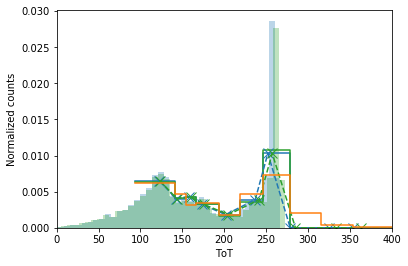

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.8778000305864223 0.12219996941357769 0.0029470480219830376 17.4950705

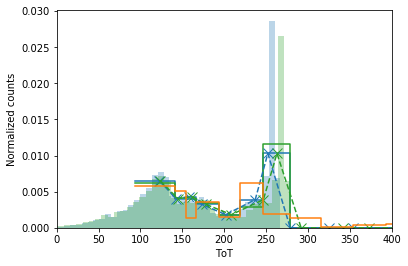

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.8092310492176126 0.19076895078238743 0.004600698852519906 17.06582543

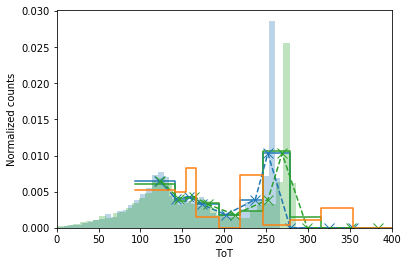

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.7348366830546152 0.26516331694538475 0.006394838169407351 16.60011310

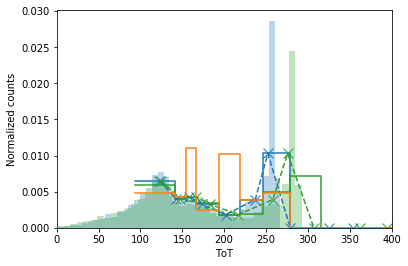

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.6538416421321046 0.3461583578678954 0.008348163332143428 16.093080243

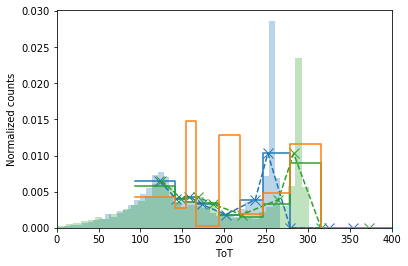

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.5653266739890923 0.4346733260109077 0.01048284358643138 15.5389722695

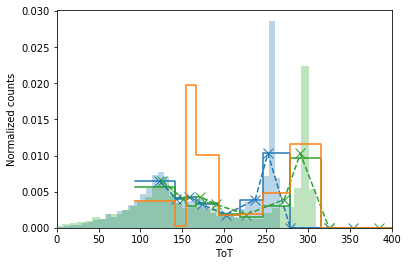

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.46819352170585365 0.5318064782941463 0.012825365157255025 14.93091404

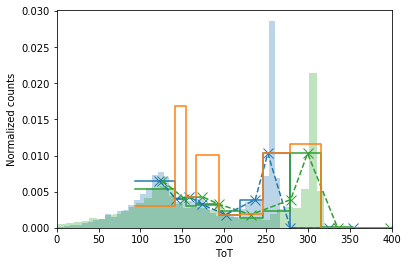

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.3611191226648317 0.6388808773351683 0.015407635819131352 14.260623140

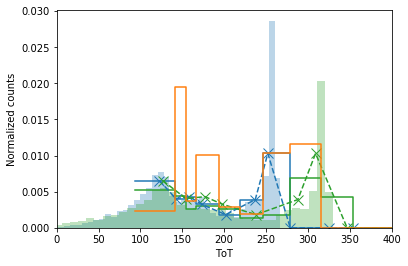

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.24249498605730874 0.7575050139426913 0.018268446904651996 13.51803031

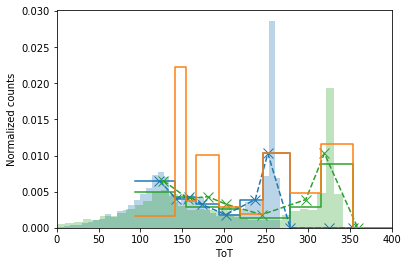

[ 6.53157970e-03 -2.48472835e-03  2.65951613e-04 -1.05910628e-03
 -1.43447798e-03  2.08302971e-03  6.39317805e-03 -1.02915732e-02
  3.65049215e-06 -7.50378941e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.0065315796977473625 -0.0024847283455067893 0.6195823276314407 93.0
-0.0024847283455067893 0.00026595161325700285 0.10703448275862082 141.0
0.00026595161325700285 -0.0010591062772414353 0.37444526627218916 154.0
-0.0010591062772414353 -0.0014344779828098905 0.2616782621042172 166.0
-0.0014344779828098905 0.002083029707780207 0.3113502042471825 194.0
0.002083029707780207 0.006393178049864678 0.6741793062021324 219.0
0.006393178049864678 -0.010291573165824663 0.18939743483073257 246.0
-0.010291573165824663 3.6504921471829757e-06 0.0003547069129630447 279.0
3.6504921471829757e-06 -7.503789413653895e-06 0.2567567567567568 316.0
-7.503789413653895e-06 0.0 0 354.0
0.1103458346409174 0.8896541653590826 0.02145543538883357 12.6907702516

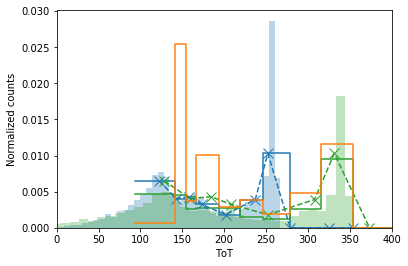

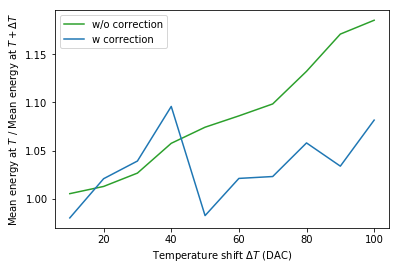

[[0.98004989 1.00525535]
 [1.02078281 1.01275208]
 [1.03915571 1.02661486]
 [1.09586887 1.05757212]
 [0.98245248 1.07429287]
 [1.02109372 1.086061  ]
 [1.02305342 1.09847396]
 [1.05796313 1.13236404]
 [1.03382692 1.17103823]
 [1.08167779 1.18542788]]


In [13]:
idx = 118
pixelData = data[idx]
# pixelData = np.random.normal(200, 20, 5000) # + list(np.random.normal(26, 1, 3000)) + list(np.random.normal(40, 10, 1000))
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 1000)]
TAdd = 10

def correctDosi(pixelData, TAdd, idx):
    pixelDataAtT = pttt.getRealToT(pixelData, Toffset, Toffset + TAdd, slope[idx], offset[idx])

    p = paramsDict[idx]
    binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
    # print binEdgesToT

    fig, ax = plt.subplots()
    # ax.set_yscale("log", nonposy='clip')
    # Measured spectrum
    _ = ax.hist(pixelData, bins=50, alpha=.3, density=True, color='C0')
    hist, bins = np.histogram(pixelData, bins=binEdgesToT, density=True)
    ax.step(bins[:-1], hist, where='post', color='C0')

    # Spectrum at specified temperature
    _ = ax.hist(pixelDataAtT, bins=50, alpha=.3, density=True, color='C2')
    histAtT, binsAtT = np.histogram(pixelDataAtT, bins=binEdgesToT, density=True)
    binsAtT_, histAtT_ = binsAtT, histAtT
    ax.step(binsAtT[:-1], histAtT, where='post', color='C2')

    binEdgesCorr = getCorrectedBins(bins, hist)
    ax.plot(np.append(binEdgesCorr, 0)[:-1], hist[:-1], marker='x', markersize=10, ls='--', color='C0')

    binsAtT = pttt.getRealToT(binEdgesCorr, Toffset, Toffset + TAdd, slope[idx], offset[idx])
    ax.plot(np.append(binsAtT, 0)[:-1], hist[:-1], marker='x', markersize=10, ls='--', color='C2')

    bw_ = binsAtT - np.diff(np.append(binsAtT, 0))
    # ax.step(bw_[1:], hist[:-2], where='post', color='C3')

    diffCorr = (binEdgesToT[1:-1] - binEdgesCorr)
    diffT = (binEdgesToT[1:-1] - binsAtT)
    '''
    print hist
    print
    print diffCorr[hist[:-1] > 0]
    print diffT[hist[:-1] > 0]
    print
    print (diffCorr / diffT)[hist[:-1] > 0]
    print (diffT / diffCorr)[hist[:-1] > 0]
    print
    print (binEdgesCorr - binsAtT)[hist[:-1] > 0]
    print 
    print (histAtT/hist)[hist > 0]
    print (hist/histAtT)[hist > 0]
    '''

    hNew = np.asarray(list(hist))
    hAdd = 0

    for idx, h in enumerate(hist[:-1]):
        # h += hAdd
        # if h == 0:
        #    continue

        bw = float(binEdgesToT[idx+1] - binEdgesToT[idx])
        bwn = float(binEdgesToT[idx+2] - binEdgesToT[idx+1])
        
        # if TAdd > 40:
        fac = ((diffCorr[idx] - diffT[idx]) / bw)
        fac = (0.25 - diffT[idx] / bw) / (0.25 - diffCorr[idx] / bw)
        # fac = 0.5 + (diffT[idx] / bw)
        # fac = abs(1 - diffCorr[idx]/diffT[idx])
        if fac > 1:
            fac = 1./fac
        # print fac, h, (1 - 1./ diffT[idx]), (abs(binsAtT/binEdgesCorr)[idx])
        # print binEdgesToT[idx+1], binEdgesToT[idx], diffT[idx], diffCorr[idx], 1./fac, fac
        if fac < 0:
            if diffT[idx] > 0:
                continue
            else:
                fac = 0
        # fac = 1. / abs(fac)

        # fac = (1 - 1./ diffT[idx]) # * (abs(binsAtT/binEdgesCorr)[idx])
        # if fac > 1:
        #    fac = 1. / fac

        # fac = 0.
        # hNew.append( h * fac )

        print fac, 1 - fac, h * (1 - fac) / bwn * bw, diffT[idx], bwn

        idx_ = 0
        if diffT[idx] < 0 and abs(diffT[idx]) >= bwn:
            idx_ = 1

        try:
            if fac == 0:
                print 'One'
                hNew[idx + idx_ + 1] = h / bw * bwn
            else:
                print 'Two', idx_
                hNew[idx + idx_ + 1] += hNew[idx] * (1 - fac) / bwn * bw
                hNew[idx] *= fac
        except:
            pass

        # hAdd = h * (1 - fac)
        
    # ax.step(bins[:-2], hNew, where='post', color='C1')
    ax.step(bins[:-1], hNew, where='post', color='C1')

    ax.set_xlim(0, 400)
    ax.set_xlabel('ToT')
    ax.set_ylabel('Normalized counts')
    plt.show()

    return histogramMean(bins, hist), histogramMean(binsAtT_, histAtT_), histogramMean(bins, hNew), histogramMean(bw_[1:], hist[:-3])

fracList = []
Trange = np.arange(10, 110, 10)
for T in Trange:
    a, b, c, d = correctDosi(pixelData, T, idx)
    fracList.append((b/c, b/a))
    
fracList = np.asarray(fracList)
plt.plot(Trange, fracList[:,1], color='C2', label='w/o correction')
plt.plot(Trange, fracList[:,0], color='C0', label='w correction')
plt.legend(loc='best')
plt.xlabel(r'Temperature shift $\Delta T$ (DAC)')
plt.ylabel(r'Mean energy at $T$ / Mean energy at $T + \Delta T$')
plt.show()
print fracList

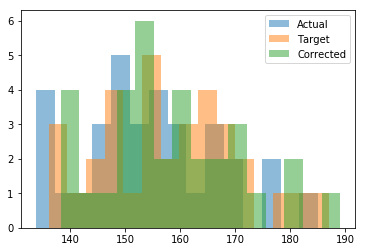

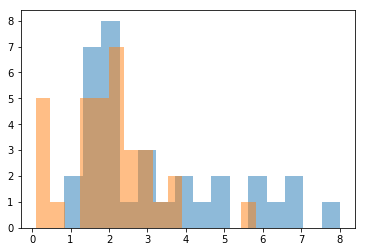

[ 7.8169e+04 -6.0547e+04 -5.0080e+03  5.8420e+03 -2.3400e+02  2.2453e+04
 -4.4610e+03 -2.0729e+04 -1.3781e+04 -1.6940e+03 -3.0000e+00 -4.0000e+00
 -2.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00]
78169.0 -60547.0 0.7745653647865521 12
-60547.0 -5008.0 0.08271260343204453 18
-5008.0 5842.0 0.1427593289969189 21
5842.0 -234.0 0.020027387880862717 24.5
-234.0 22453.0 0.9895782300806129 33.5
22453.0 -4461.0 0.0993408453213379 43
-4461.0 -20729.0 0.21520575039799314 53.5
-20729.0 -13781.0 0.3351825944329201 66.5
-13781.0 -1694.0 0.12292286481387418 81.5
-1694.0 -3.0 0.0017709563164108619 97
-3.0 -4.0 0.25 113
-4.0 -2.0 0.5 131.5
-2.0 -1.0 0.5 151.5
-1.0 0.0 0 173
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
nan nan nan 12
nan nan nan 18
nan nan nan 21
nan nan nan 24.5
nan nan nan 33.5
nan nan nan 43
nan nan nan 53.5
nan nan nan 66.5
nan nan nan 81.5
nan nan nan 97
nan nan nan 113
nan nan nan 131.5
nan nan nan 151.5
nan nan nan 173
nan nan nan 200.5


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


(12, 100)

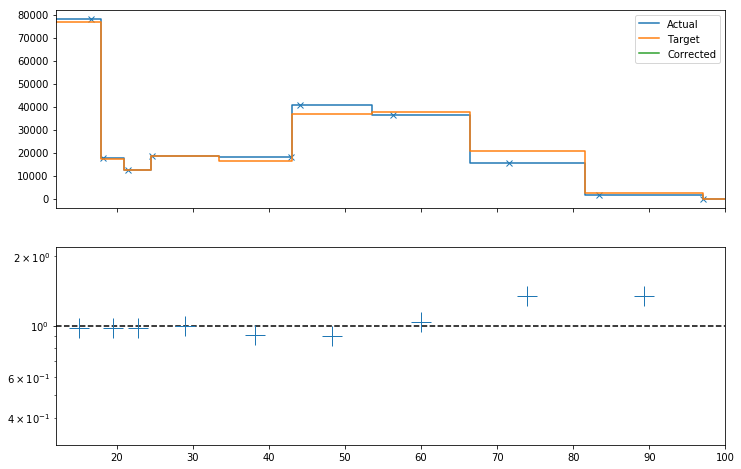

In [14]:
meanActual, meanCorrected, meanTarget = np.asarray(meanDict['actual']), np.asarray(meanDict['corrected']), np.asarray(meanDict['target'])
plt.hist(meanActual, bins=15, alpha=.5, label='Actual')
plt.hist(meanTarget, bins=15, alpha=.5, label='Target')
plt.hist(meanCorrected, bins=15, alpha=.5, label='Corrected')
plt.legend()
plt.show()

plt.hist(abs(meanActual - meanTarget), bins=15, alpha=.5)
plt.hist(abs(meanCorrected - meanTarget), bins=15, alpha=.5)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(np.append(getCorrectedBins(binEdges, histActual), 0), histActual, marker='x', ls='', color='C0')
ax[0].step(binEdges[:-1], histActual, where='post', label='Actual', color='C0')
ax[0].step(binEdges[:-1], histTarget, where='post', label='Target', color='C1')
ax[0].plot(np.append(getCorrectedBins(binEdges, histCorrected), 0), histCorrected, marker='x', ls='', color='C2')
ax[0].step(binEdges[:-1], histCorrected, where='post', label='Corrected', color='C2')
ax[1].axhline(y=1, ls='--', color='k')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histActual, markersize=20, ls='', marker='+')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histCorrected, markersize=20, ls='', marker='+')
ax[0].legend()
plt.xlim(12, 100)

[7.67112510e-03 8.52347233e-03 1.62189502e-01 8.58881895e-01
 9.04385275e-02 7.35453898e-02 1.00000000e+00 5.11408340e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[ 7.67112510e-03  8.52347233e-04  1.53666030e-01  6.96692393e-01
 -7.68443368e-01 -1.68931376e-02  9.26454610e-01 -9.99488592e-01
 -5.11408340e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.007671125098347757 0.0008523472331497519 0.8888888888888887 12.0
0.0008523472331497519 0.1536660297478551 0.9944532488114105 18.0
0.1536660297478551 0.696692393191213 0.7794348965919021 21.0
0.696692393191213 -0.7684433677953078 0.04668592222348861 24.5
-0.7684433677953078 -0.016893137643479272 0.021983581811560564 33.5
-0.016893137643479272 0.9264546101682215 0.981765822677042 43.0
0.9264546101682215 -0.9994885916601102 0.036535675395044875 53.5
-0.9994885916601102 -0.000511408339889850

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


[[0.37755692855300554, 39.97450360402571, 0.0, 0.0040000000000000036, 8.228211853373507, 0.15878192214378067, 8.98430685438553e-09, -1.589993494901369e-05, 0.000830272011926919, -0.0864983623090023, 1.1766091729729389], [0.5663353928295083, 59.96175540603856, 22.153279889028965, 0.006000000000000005, 12.342317780060261, 0.23817288321567098, 1.3476460281578293e-08, -1.0599956632675795e-05, 0.0012454080178903783, -0.057665574872668206, 1.764913759459408]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in divide


[[4.46105928e-01 4.72323251e+01]
 [1.94718256e+01 5.98695150e-03]
 [1.23411833e+01 2.04364515e-01]]


(0, 100)

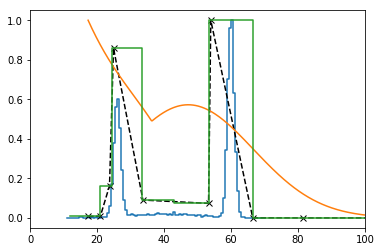

In [15]:
import scipy.interpolate

# randomData = pixelData 
randomData = list(np.random.normal(60, 1, 5000)) + list(np.random.normal(26, 1, 3000)) + list(np.random.normal(40, 10, 1000))
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

hist, bins = np.histogram(randomData, bins=binEdges, density=True)
hist /= max(hist)
print hist

# Use corrected bin centers
binEdges_ = getCorrectedBins(bins, hist)

# Show input data
histIn, binsIn = np.histogram(randomData, bins=100, density=True)
histIn /= max(histIn)
plt.step(binsIn[:-1], histIn, where='post')

# Plot corrected bin positions
hist_ = hist[:-1] # * np.diff(np.append(binEdges_, 0))
plt.plot(binEdges_, hist_/max(hist_), marker='x', ls='--', color='k')

# Find peaks
sign = np.sign(np.insert(np.diff(hist_), 0, 1))
sign = sign[sign != 0]
peakIdx = (np.argwhere(np.diff(sign) < 0) + 2).flatten()
print 'Peaks:', peakIdx

peaks = np.asarray(binEdges_)[peakIdx]
sigmas = [2] * len(peaks)
As = np.asarray(hist_/max(hist_))[peakIdx]
offsetList = [0.] * len(peaks)

def multiGaussPlot(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    return y

wBG, wAREA = False, False
def multiGauss(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    if wAREA:
        areaList = []
        for idx in range(len(binEdges) - 1):
            b1, b2 = binEdges[idx], binEdges[idx+1]
            y_ = yfine[np.logical_and(xfine >= b1, xfine < b2)]
            if not any(y_):
                areaList.append( 0 )
                continue
            x_ = xfine[np.logical_and(xfine >= b1, xfine < b2)]

            areaList.append( scipy.integrate.simps(y_, x_) )
            # print areaList
                
        areaList = np.asarray(areaList)
        areaList /= float(np.max(areaList))
        
        '''
        plt.clf()
        plt.step(bins[:-1], hist, where='post')
        plt.step(bins[:-1], areaList, where='post')
        plt.step(xfine, yfine, where='post')
        plt.xlim(12, 70)
        plt.show()
        '''
        
        error = np.asarray(hist) / areaList
        errMean, errStd = np.nanmean( error ), np.nanstd( error )
        error = np.nansum(np.abs( np.asarray(hist) / areaList - 1 ))
        # print error
        # print errStd
        return errStd
    
    else:
        errStd, error = 0, 0
        return np.sqrt(np.square(y - hist[:-1]))
    
def polyArea(x, poly):
    return np.asarray([1./(k + 1) * x**(k + 1) for k in range(len(poly))])

def multiGaussArea(x1, x2, *p):
    # poly = p[-3:]
    # pA = np.sum(polyArea(x2, poly) - polyArea(x1, poly))
    x = np.linspace(x1, x2, 100)
    return scipy.integrate.simps(multiGauss(x, *p), x) # scipy.integrate.quad(multiGauss, x1, x2)[0]

p0 = np.hstack((np.vstack((As, peaks, sigmas)).T.flatten(), [0.001]*5)).flatten()
bounds = [[0, 0, 0] * len(peaks) + [-np.inf]*5, [1, np.inf, np.inf]*len(peaks) + [np.inf]*5]
# bounds[1][2], bounds[1][5] = 3., 3.
print bounds
print p0
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=p0, bounds=bounds)
wBG = True
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
wAREA = True
bounds = [[0.8*p if p >= 0 else 1.2*p for p in popt], [1.2*p if p >= 0 else 0.8*p for p in popt]]
bounds[0][2] = 0.
# bounds[1][2] = 5.

print bounds
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
print np.reshape(popt[:-5], (3, -1))

# p = np.polyfit(x_, hist__/max(hist__), 13)
# f = np.poly1d(p)
# f = scipy.interpolate.interp1d(binEdges_, hist_/max(hist_), kind='cubic')
# f = KDE(np.append(binEdges_, 0), hist_)

x = np.linspace(min(binEdges_), max(binEdges_), 1000)
wArea = False
yFit = multiGaussPlot(x, *popt)
plt.plot(x, yFit / np.max(yFit))

# plt.plot(x, f(x))
plt.step(bins[:-1], hist, where='post')
plt.xlim(0, 100)
# plt.ylim(0, 1.05)

In [16]:
test = np.linspace(12, 15, 100)
scipy.integrate.simps(multiGauss(test, *p0), test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1315: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in divide


IndexError: tuple index out of range

In [17]:
areaList = []
for idx in range(len(binEdges) - 1):
    b1, b2 = binEdges[idx], binEdges[idx+1]
    areaList.append( scipy.integrate.simps(np.linspace(b1, b2, 100), *p) )
    print areaList

areaList = np.asarray(areaList)
error = np.sqrt( np.sum(np.square( np.asarray(hist) / areaList - 1 )) )


TypeError: simps() argument after * must be an iterable, not numpy.float64

# Dose Temperature Stability
Includes:

In [16]:
sys.path.insert(0, '../../../getConversionFactors/')
sys.path.insert(0, '../../../csv/')

import plot_csv_support as pcs
import getConversionFactors as gcf
import getConversionFactors_poly as gcfp

reload(pcs)
reload(gcf)
reload(gcfp)

<module 'getConversionFactors_poly' from '../../../getConversionFactors/getConversionFactors_poly.pyc'>

In [365]:
binEdgesTh = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
        'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
        'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}

# binEdgesTh = {'vac': np.linspace(12, 400, 17), 'al': list(np.linspace(12, 100, 8)) + list(np.linspace(105, 500, 9)), 'sn': np.linspace(12, 200, 17)}
# list(np.linspace(12, 100, 8)) + list(np.linspace(105, 300, 9))
# [12, 60, 100, 135, 165, 180, 200, 215, 225, 230, 235, 240, 245, 250, 255, 260, 430]

for key in binEdgesTh.keys():
    print binEdgesTh[key]
    print np.diff(binEdgesTh[key])
    print np.mean( np.diff(binEdgesTh[key])[:-1] )
    
polyParams = [-6.13432151e-09,  2.08479453e-06,  6.76750181e-10, -4.04786053e-07, 6.04542804e-05, 5.54387308e-09, -3.50905545e-06,  5.37851109e-04] 
degs = [2, 3, 3]
alphaPoly = gcfp.alphaPolyDev(polyParams, degs, binEdgesTh)
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']
idx = 13

[12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
[  6.    3.    3.5   9.    9.5  10.5  13.   15.   15.5  16.   18.5  20.
  21.5  27.5  35.5 194. ]
14.933333333333334
[32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430]
[  5.   10.   10.5  11.   11.5  11.5  12.5  13.   14.   14.   18.5  20.
  24.   27.   35.  160.5]
15.833333333333334
[12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]
[  5.   14.    9.    5.5   5.   10.    7.5  23.   11.5  30.5  15.   15.
  33.   24.   37.  173. ]
16.333333333333332


In [391]:
import scipy.integrate

def alphaPolyShow(p, deg, x):
    resList = []
    p1, p2, p3 = deg
    idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

    title = ['vac', 'al', 'sn']
    for i in range(3):
        f = np.poly1d(np.asarray(p)[idxList[i]])
        resList.append( f(x) )

    return resList 

def alphaInt(x, y, edges):
    x = np.asarray(x)
    y = np.asarray(y)
    
    res = []
    for i in range(len(edges) - 1):
        try:
            y_ = y[np.logical_and(x > edges[i], x <= edges[i+1])]
            x_ = x[np.logical_and(x > edges[i], x <= edges[i+1])]
            res.append( scipy.integrate.trapz(y_, x=x_) )
            # print x_, y_, res
        except:
            res.append( 0 )
        
    return res

def histMean(bins, hist):
    bw = np.asarray(bins[:-1]) + 0.5 * np.diff(bins)
    mean = np.dot(bw, hist) / np.sum(hist)
    return mean, 1./np.sum(hist) * (np.dot(hist, np.square(np.asarray(bw) - mean)))

## Generate random data

41.11535796753125


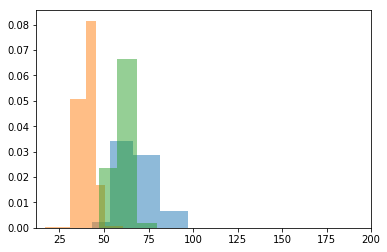

In [465]:
# Random data in ToT
ToTvac = list(np.random.normal(250, 10, 5000)) + list(np.random.normal(300, 2, 5000))
ToTal = np.random.normal(200, 10, 10000)
ToTsn = np.random.normal(250, 10, 10000)
data_vac = getDataAtTSingle(ToTvac, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
data_al = getDataAtTSingle(ToTal, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
data_sn = getDataAtTSingle(ToTsn, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)

# plt.hist(data_vac, bins=50, density=True, alpha=.5)
plt.hist(data_vac, bins=binEdgesTh['vac'], density=True, alpha=.5)
plt.hist(data_al, bins=binEdgesTh['al'], density=True, alpha=.5)
plt.hist(data_sn, bins=binEdgesTh['sn'], density=True, alpha=.5)
plt.xlim(12, 200)

hist_vac, bins = np.histogram(data_vac, bins=binEdgesTh['vac'])
hist_al, bins = np.histogram(data_al, bins=binEdgesTh['al'])
hist_sn, bins = np.histogram(data_sn, bins=binEdgesTh['sn'])

hist = np.hstack((hist_vac, hist_al, hist_sn))
dose = np.dot(hist, alphaPoly)
print dose

## Apply Temperature Shift

[   0    0    0    0  414 4490 5096    0    0    0    0    0    0    0
    0    0]
[   0 2302 7633   65    0    0    0    0    0    0    0    0    0    0
    0    0]
[   0.         1353.48390607  871.37149534 2521.44093426 2598.54132301
 2628.62498705   26.53735428    0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
32.899825 44.24320558356959
13.88124762465331 [0.         1.89487747 0.78423435 1.38679251 1.29927066 2.62862499
 0.01990302 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

44.24320558356959 44.3532597067549
[18.4  31.9  40.55 46.   51.5  61.25 70.3 ]
[0.03238942 0.06781435 0.22664497 0.47646239 0.11534659 0.04921836
 0.03212392] [14.   9.   5.5  5.  10.   7.5 23. ] [1353.48390607  871.37149534 2521.44093426 2598.54132301 2628.62498705
   26.53735428    0.        ]
6.95409412519929

[   1 4797 5196    6    0    0    0    0    0    0    0    0    0    0
    0    0]


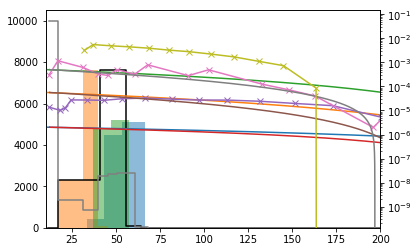

42.309922371653755
[   0    0    0    0  143 4417 5321  119    0    0    0    0    0    0
    0    0]
[   0 1343 8421  236    0    0    0    0    0    0    0    0    0    0
    0    0]
[   0.          894.15847544 1718.28859173 3513.32414054 3193.93103685
  680.29775543    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
34.12665 42.65770852656914
13.594907821609562 [0.         1.25182187 1.54645973 1.93232828 1.59696552 0.68029776
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

42.65770852656914 42.37188706206018
[31.9  40.55 46.   51.5 ]
[0.09488327 0.48428261 0.30539724 0.11543688] [ 9.   5.5  5.  10. ] [1718.28859173 3513.32414054 3193.93103685  680.29775543]
6.198858812958398

[   0 2387 7567   46    0    0    0    0    0    0    0    0    0    0
    0    0]


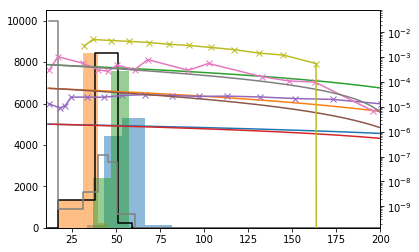

41.42260652481353
[   0    0    0    0   32 3588 1389 4991    0    0    0    0    0    0
    0    0]
[   0  719 8625  646   10    0    0    0    0    0    0    0    0    0
    0    0]
[0.00000000e+00 5.36985672e+02 3.27096542e+03 3.98129623e+03
 1.81951631e+03 3.90215157e+02 1.02121200e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
35.154 41.34205032250753
14.356397879875836 [0.00000000e+00 7.51779941e-01 2.94386887e+00 2.18971293e+00
 9.09758155e-01 3.90215157e-01 7.65908998e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

41.34205032250753 40.82666793158284
[31.9  40.55 46.   51.5 ]
[0.06298169 0.75080624 0.12766912 0.05854295] [ 9.   5.5  5.  10. ] [3270.9654162  3981.29623285 1819.51630922  390.21515744]
5.920044638535148

[   0  814 8828  358    0    0    0    0    0    0    0    0    0    0
   

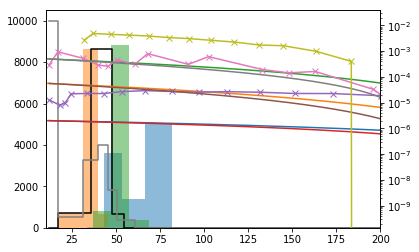

41.21668229074061
[   0    0    0    0    5 2180 2814 5001    0    0    0    0    0    0
    0    0]
[   0  349 7998 1595   58    0    0    0    0    0    0    0    0    0
    0    0]
[   0.          289.99498767 4607.44763091 3657.01701135 1252.82316897
  192.71720109    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
36.327525 40.23362504606868
13.872061860431813 [0.         0.40599298 4.14670287 2.01135936 0.62641158 0.1927172
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

40.23362504606868 39.76930646080751
[31.9  40.55 46.   51.5 ]
[0.0338686  0.89213189 0.04894725 0.02505226] [ 9.   5.5  5.  10. ] [4607.44763091 3657.01701135 1252.82316897  192.71720109]
5.706801647222256

[   0  218 8187 1595    0    0    0    0    0    0    0    0    0    0
    0    0]


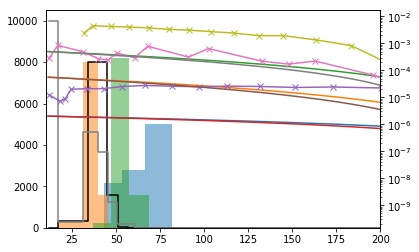

40.961349785566064
[   0    0    0    0    1  932 4038 5029    0    0    0    0    0    0
    0    0]
[   0  152 6554 3026  263    5    0    0    0    0    0    0    0    0
    0    0]
[0.00000000e+00 1.39508569e+02 5.14498251e+03 3.15542251e+03
 1.41064312e+03 1.47643042e+02 1.80024360e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
37.8578 39.6927483231116
13.816893566313063 [0.00000000e+00 1.95311997e-01 4.63048426e+00 1.73548238e+00
 7.05321561e-01 1.47643042e-01 1.35018270e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

39.6927483231116 39.69101215330573
[31.9  40.55 46.   51.5 ]
[0.08343133 0.758423   0.10308125 0.05506441] [ 9.   5.5  5.  10. ] [5144.98251213 3155.4225099  1410.64312299  147.6430421 ]
5.988258905845746

[   0   39 5611 4336   14    0    0    0    0    0    0    0    0    0
   

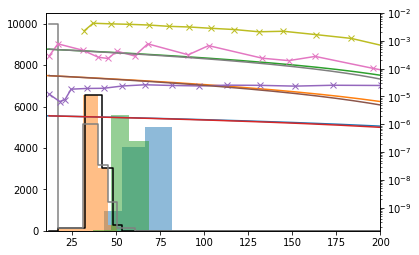

39.91555438025598
[   0    0    0    0    0  256 4432 4285 1027    0    0    0    0    0
    0    0]
[   0   49 4576 4484  834   57    0    0    0    0    0    0    0    0
    0    0]
[0.00000000e+00 9.99183005e+01 4.53986468e+03 4.48781740e+03
 8.11748978e+02 6.00449665e+01 6.05670086e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
39.85105 39.98218642785989
14.407582290256412 [0.00000000e+00 1.39885621e-01 4.08587821e+00 2.46829957e+00
 4.05874489e-01 6.00449665e-02 4.54252565e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

39.98218642785989 39.77527902843966
[31.9  40.55 46.   51.5 ]
[0.05787496 0.82378489 0.0777286  0.04061155] [ 9.   5.5  5.  10. ] [4539.86468196 4487.81740338  811.74897761   60.0449665 ]
5.846450034827119

[   0    5 2489 7294  212    0    0    0    0    0    0    0    0    0
 

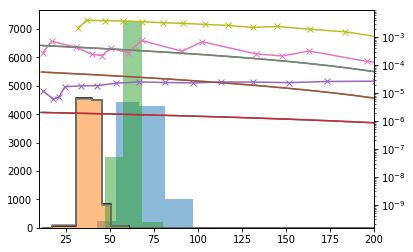

40.57194236460353
[   0    0    0    0    0   55 3509 1436 5000    0    0    0    0    0
    0    0]
[   0   20 2646 4959 2068  307    0    0    0    0    0    0    0    0
    0    0]
[   0.          417.67842095 4119.21457318 4119.76994697 1121.52118072
  221.81587818    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
42.271275 40.23642235364869
14.139307211962397 [0.         0.58474979 3.70729312 2.26587347 0.56076059 0.22181588
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

40.23642235364869 39.85203625972829
[18.4  31.9  40.55 46.   51.5  61.25]
[0.01249651 0.03273336 0.87021217 0.04734543 0.02422668 0.01298585] [14.   9.   5.5  5.  10.   7.5] [ 417.67842095 4119.21457318 4119.76994697 1121.52118072  221.81587818
    0.        ]
5.8321061213326555

[   0    0  636 7891 1471    2    0    0    0    0    0    0    0    0
    0    0]


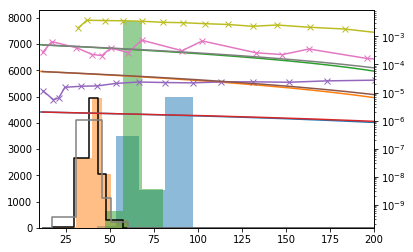

40.568653279730675
[   0    0    0    0    0    5 1685 3300 5010    0    0    0    0    0
    0    0]
[   0    6 1239 4109 3471 1171    4    0    0    0    0    0    0    0
    0    0]
[0.00000000e+00 3.67382911e+02 3.98356960e+03 4.40524887e+03
 7.23394044e+02 5.20205440e+02 1.99134223e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
45.164375 40.79867310593764
14.000050889369112 [0.00000000e+00 5.14336075e-01 3.58521264e+00 2.42288688e+00
 3.61697022e-01 5.20205440e-01 1.49350667e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

40.79867310593764 40.216541027772394
[18.4  31.9  40.55 46.   51.5  61.25]
[0.00989272 0.02490076 0.89106426 0.04260138 0.02070619 0.01083469] [14.   9.   5.5  5.  10.   7.5] [3.67382911e+02 3.98356960e+03 4.40524887e+03 7.23394044e+02
 5.20205440e+02 1.99134223e-01]
5.7647872

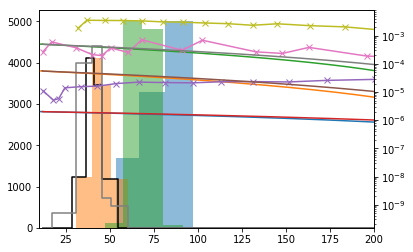

39.87924160765155
[   0    0    0    0    0    1  456 4239  348 4956    0    0    0    0
    0    0]
[   0    2  472 2494 3890 3068   74    0    0    0    0    0    0    0
    0    0]
[   0.          207.59129552 3327.87313201 4046.4292649  1861.63612532
  556.47018225    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
48.5171 41.94224231251232
16.027480084696492 [0.         0.29062781 2.99508582 2.2255361  0.93081806 0.55647018
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

41.94224231251232 41.634916748355195
[12.5  18.4  31.9  40.55 46.   51.5  61.25 70.3 ]
[0.02549122 0.03187966 0.07473617 0.53907194 0.18495899 0.07852457
 0.03887136 0.02646608] [ 5.  14.   9.   5.5  5.  10.   7.5 23. ] [   0.          207.59129552 3327.87313201 4046.4292649  1861.63612532
  556.47018225    0.            0.        ]
6.821588354488034

[   0    0    8 1611 7399  976 

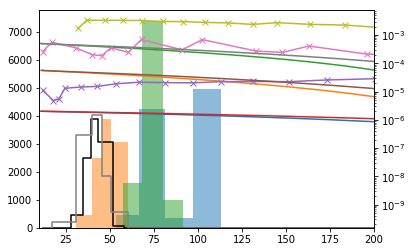

41.33495346744899
[   0    0    0    0    0    0   66 3128 1802 5004    0    0    0    0
    0    0]
[   0    1  147 1081 2881 5366  498   26    0    0    0    0    0    0
    0    0]
[   0.           86.59050199 2730.07288512 3888.90355302 2857.64404022
  418.37295422   10.7508231     7.66524234    0.            0.
    0.            0.            0.            0.            0.
    0.        ]
52.161975 42.97336280941664
14.181459771525594 [0.         0.1212267  2.4570656  2.13889695 1.42882202 0.41837295
 0.00806312 0.01763006 0.         0.         0.         0.
 0.         0.         0.         0.        ]

42.97336280941664 42.69331264003138
[18.4  31.9  40.55 46.   51.5  61.25 70.3 ]
[0.03758821 0.08341357 0.38115165 0.30517987 0.10832744 0.05053822
 0.03380104] [14.   9.   5.5  5.  10.   7.5 23. ] [  86.59050199 2730.07288512 3888.90355302 2857.64404022  418.37295422
   10.7508231     7.66524234]
7.138925449294486

[   0    0    0  236 5137 4463  164    0    0    0    0    0    0 

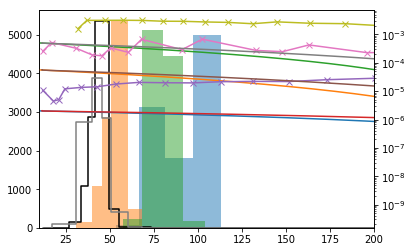

40.65080689975878
[   0    0    0    0    0    0    3  980 3758  259 5000    0    0    0
    0    0]
[   0    0   29  352 1384 5944 2027  264    0    0    0    0    0    0
    0    0]
[   0.           21.22468317 1689.66472957 4414.25226588 2731.78148674
  996.85431445  115.30055442   30.92196577    0.            0.
    0.            0.            0.            0.            0.
    0.        ]
56.362425 44.493319737702734
16.214860707793527 [0.         0.02971456 1.52069826 2.42783875 1.36589074 0.99685431
 0.08647542 0.07112052 0.         0.         0.         0.
 0.         0.         0.         0.        ]

44.493319737702734 44.551905737780764
[12.5  18.4  31.9  40.55 46.   51.5  61.25 70.3 ]
[0.02390666 0.02931223 0.06073484 0.19396178 0.50764142 0.10916058
 0.04564468 0.0296378 ] [ 5.  14.   9.   5.5  5.  10.   7.5 23. ] [   0.           21.22468317 1689.66472957 4414.25226588 2731.78148674
  996.85431445  115.30055442   30.92196577]
6.797125394580738

[   0    0    0   15 1308 6

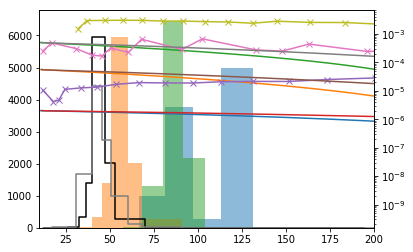

41.21020689577838


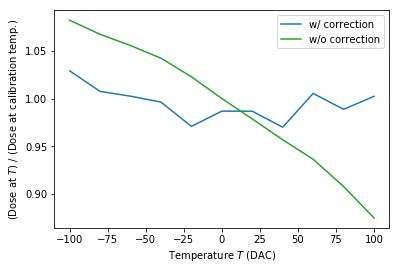

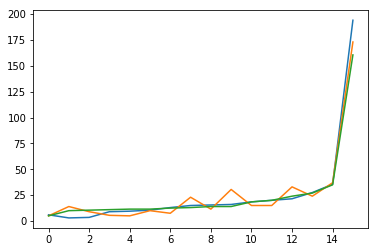

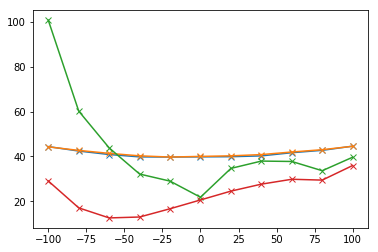

In [466]:
reload(gcfp)

dose_temp = []
dose_old = []
w_list = []
TAddRange = np.arange(-100, 120, 20)
for TAdd in TAddRange:
    data_vac_temp = getDataAtTSingle(ToTvac, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)
    data_al_temp = getDataAtTSingle(ToTal, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)
    data_sn_temp = getDataAtTSingle(ToTsn, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)

    fig, ax = plt.subplots()
    ax.hist(data_vac_temp, bins=binEdgesTh['vac'], density=False, alpha=.5)
    ax.hist(data_al_temp, bins=binEdgesTh['al'], density=False, alpha=.5)
    ax.hist(data_sn_temp, bins=binEdgesTh['sn'], density=False, alpha=.5)
    
    ax.hist(data_vac_temp, bins=100, density=True, alpha=.5)
    ax.hist(data_al_temp, bins=100, density=True, alpha=.5)
    ax.hist(data_sn_temp, bins=100, density=True, alpha=.5)
    x = np.linspace(10, 450, 5000)
    alphaShow = alphaPolyShow(polyParams, degs, x)
    ax2 = ax.twinx()
    for i in range(3):
        # ax2.plot(x, np.sin(x* + i))
        ax2.semilogy(x, alphaShow[i])
    
    hist_vac_temp, bins = np.histogram(data_vac_temp, bins=binEdgesTh['vac'])
    hist_al_temp, bins = np.histogram(data_al_temp, bins=binEdgesTh['al'])
    hist_sn_temp, bins = np.histogram(data_sn_temp, bins=binEdgesTh['sn'])
    
    hist_temp = np.hstack((hist_vac_temp, hist_al_temp, hist_sn_temp))
    p = paramsDict[idx]
    
    # Scale x-axis with temperature
    new_x = getDataAtTSingle(tte.EnergyToToT(x, p['a'], p['b'], p['c'], p['t'], p['h'], p['k']), Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
    
    binEdgesNew = {}
    titles = ['vac', 'al', 'sn']
    for t in titles:
        binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdgesTh[t]), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
        binEdges = getDataAtTSingle(binEdgesToT, Toffset + TAdd, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
        binEdgesNew[t] = binEdges

    alphaPoly_ = gcfp.alphaPolyDev(polyParams, degs, binEdgesNew)
    '''
    alphaPolY = []
    for i in range(3):
        alphaPolY += list(np.reshape(alphaPoly_, (3, -1))[i] * np.diff(binEdgesTh[titles[i]]) / np.diff(binEdgesNew[titles[i]]))
    alphaPoly_ = alphaPolY
    '''
    
    # print np.reshape(alphaPoly_, (3, -1))
    # print len(x), len(new_x), len(alphaShow[0])
    
    alphaPoly__ = []
    for i in range(3):
        ax2.semilogy(new_x, alphaShow[i])
        ax2.semilogy(binEdgesTh[titles[i]][:-1], np.reshape(alphaPoly_, (3, -1))[i], marker='x')
        be = np.diff(binEdgesTh[titles[i]])
        h = np.reshape(hist_temp, (3, -1))[i]
        if np.count_nonzero(h):
            # print be
            # print h / float(np.sum(h)) * be
            e = binEdgesTh[titles[i]][np.argmax(h)]
            
            print h
            hMean, hSigma = histMean(binEdgesTh[titles[i]], h)
            hMean_ToT = np.around(tte.EnergyToToT([hMean], p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))[0]
            hMean_temp = getDataAtTSingle([hMean_ToT], Toffset + TAdd, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)[0]
            hSigma_ToT = np.around(tte.EnergyToToT([hSigma], p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))[0]
            hSigma_temp = getDataAtTSingle([hSigma_ToT], Toffset + TAdd, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)[0]
            
            # print binEdgesNew[titles[i]]
            # print binEdgesTh[titles[i]]
            h = rb.rebin(np.asarray(binEdgesNew[titles[i]]), np.asarray(h, dtype=float), np.asarray(binEdgesTh[titles[i]]), interp_kind='piecewise_constant')
            if i == 1:
                ax.step(binEdgesNew[titles[i]][:-1], np.reshape(hist_temp, (3, -1))[i], where='post', color='k')
                ax.step(binEdgesTh[titles[i]][:-1], h, where='post', color='gray')
            h[0] = 0
            hMean_t, hSigma_t = histMean(binEdgesTh[titles[i]], h)
            if i == 1:
                print h
                w_list.append( (hMean_t, hMean_temp, hSigma_t, hSigma_temp) )
                print hMean, hMean_temp
            
                # w = 1./float(np.count_nonzero(h)) * np.sum(be)
                # w = 1. / np.sum(h / float(np.sum(h)) * binEdgesTh[titles[i]][:-1]) * 800

                # w = 1./float(np.count_nonzero(h)) * np.sum(h / float(np.sum(h)) * be)
                print w, h / float(np.sum(h)) * be
            bc = binEdgesTh[titles[i]][:-1] + .1 * np.diff(binEdgesTh[titles[i]])
            h_idx = np.argwhere(np.abs(bc - hMean_temp) <= hSigma_temp).flatten()
            h_filt = np.asarray(h[h_idx])
            be_filt = np.asarray(be[h_idx])
            bc_filt = bc[h_idx]
            mean_dist = (1. / np.abs(bc - hMean_temp))[h_idx]
            # print bc, hMean_t, hSigma_t
            # print np.abs(bc - hMean_temp) <= hSigma_temp
            w = np.dot(mean_dist / np.sum(mean_dist), be_filt) # be[np.argmin(np.abs(binEdgesTh[titles[i]] - hMean_t))] # be[np.argmax(h)]
            # w = np.sum(h_filt / np.sum(h_filt) * be_filt)
            if i == 1:
                print 
                print hMean_temp, hMean_t
                print bc_filt
                print mean_dist / np.sum(mean_dist), be_filt, h_filt
                print w
                print 
            # w = 1
            # w = np.sum(h / float(np.sum(h)) * be)
            # if i == 1:
            #    w_list.append( w )
            # print w
        else:
            w = 0
        alphaPoly__ += list( np.asarray(alphaInt(new_x, alphaShow[i], binEdgesTh[titles[i]])) * (w / be))
    
    for i in range(3):
        alphaPolY += list(np.reshape(alphaPoly_, (3, -1))[i] * np.diff(binEdgesTh[titles[i]]) / np.diff(binEdgesNew[titles[i]]))
        
    alphaPoly__ = np.nan_to_num(alphaPoly__)
    # print np.reshape(alphaPoly__, (3, -1))
    plt.xlim(10, 200)
    plt.show()

    # plt.plot(x, new_x)
    
    dose_t = np.dot(hist_temp, alphaPoly__)
    print dose_t
    dose_temp.append( dose_t )
    dose_old.append(np.dot(hist_temp, alphaPoly))
    
dose_temp_resp = np.asarray(dose_temp) / dose
plt.plot(TAddRange, dose_temp_resp, color='C0', label='w/ correction')
plt.plot(TAddRange, np.asarray(dose_old) / dose, color='C2', label='w/o correction')
plt.xlabel(r'Temperature $T$ (DAC)')
plt.ylabel(r'(Dose at $T$) / (Dose at calibration temp.)')
plt.legend()
plt.show()

plt.plot(np.diff(binEdgesTh['vac']))
plt.plot(np.diff(binEdgesTh['al']))
plt.plot(np.diff(binEdgesTh['sn']))
plt.show()
plt.plot(TAddRange, w_list, marker='x')